### Import statements

In [112]:
import random 
import math
import matplotlib.pyplot as plt
import time 
import ray
import numpy as np

ray.init()

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

### Model parameters
Width and height correspond to the boundry of the specimen. Diameter d to the grain size. Set the required void ratio with variable req_void and the tolerance between aggregates with tol. The timeout variable limits the time it spends in the while loop looking for a solution that satisfies req_void > cur_void

In [97]:
width_box = 1.5
height_box = 0.5
d_max = 0.055
d_min = 0.030
tol = 0
req_void = 0.44
timeout = 120   #[seconds]

r_max = d_max/2
r_min = d_min/2

## 2D Circle Random Sequential Adsorption

### Functions

In [59]:
def intersection (r1, cen1, r2, cen2, tol):
    distan = math.sqrt((cen1[0]-cen2[0])**2+(cen1[1]-cen2[1])**2)
    min_Dis = r1+r2+tol

    if distan > min_Dis:
        return False
    else:
        return True   

In [60]:
def any_intersec (cir1, cirList, tol):
    r1 = cir1[2]
    intersec = False
    for cir2 in cirList:
        r2 = cir2[2]
        check = intersection(r1,cir1[0:2],r2,cir2[0:2],tol)
        if check:
            intersec = True
            return intersec
    return intersec

In [61]:
def random_gen (x1,x2):
    value = (x2-x1)*random.random()+x1
    return value

In [110]:
def plot(cirList):
    fig1 = plt.figure()
    for cir in cirList:
        circle1 = plt.Circle((cir[0],cir[1]),cir[2], facecolor='tab:brown',edgecolor='k')
        plt.gcf().gca().add_artist(circle1)
    plt.xlim(0, width_box)
    plt.ylim(0, height_box)
    plt.gca().set_aspect('equal','box')
    plt.show()

In [88]:
@ray.remote
def rsa_circle_enhanced():
    cirList = []
    cur_void = 1
    timeout_start = time.time()
    while req_void < cur_void and time.time() < timeout_start + timeout:
        r_cur = random_gen(r_min,r_max)
        x_cur = random_gen(r_cur,width_box-r_cur)
        z_cur = random_gen(r_cur,height_box-r_cur)
        new_Circle = [x_cur,z_cur,r_cur]

        if cirList == []:
            cirList.append(new_Circle)
        else:
            check = any_intersec(new_Circle,cirList,tol)
            if not check:
                cirList.append(new_Circle)
                cur_void = cur_void - math.pi*new_Circle[2]**2/(height_box*width_box)
    elapsed_time = round(time.time()-timeout_start,2)
    print("Found a solution in ",elapsed_time," seconds")
    return cirList, cur_void
        

In [87]:
def rsa_circle_normal():
    cirList = []
    cur_void = 1
    timeout_start = time.time()
    while req_void < cur_void and time.time() < timeout_start + timeout:
        r_cur = random_gen(r_min,r_max)
        x_cur = random_gen(r_cur,width_box-r_cur)
        z_cur = random_gen(r_cur,height_box-r_cur)
        new_Circle = [x_cur,z_cur,r_cur]

        if cirList == []:
            cirList.append(new_Circle)
        else:
            check = any_intersec(new_Circle,cirList,tol)
            if not check:
                cirList.append(new_Circle)
                cur_void = cur_void - math.pi*new_Circle[2]**2/(height_box*width_box)
    elapsed_time = round(time.time()-timeout_start,2)
    print("Found a solution in ",elapsed_time," seconds")
    return cirList, cur_void

### Main program

Found a solution in  24.18  seconds
Current void 0.4392


C:\Users\lukas\AppData\Local\Temp\ipykernel_25964\3105360968.py:4: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle1 = plt.Circle((cir[0],cir[1]),cir[2], color='tab:brown',edgecolor='b')


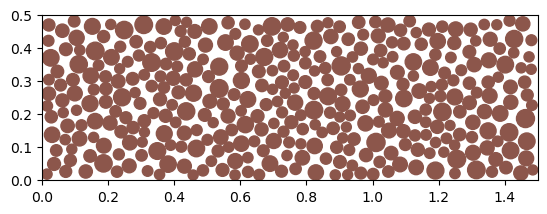

In [107]:
# future = rsa_circle_enhanced.remote()
# cirList, cur_void = ray.get(future)
# print("Current void",round(cur_void,4))
# plot(cirList)

cirList, cur_void = rsa_circle_normal()
print("Current void",round(cur_void,4))

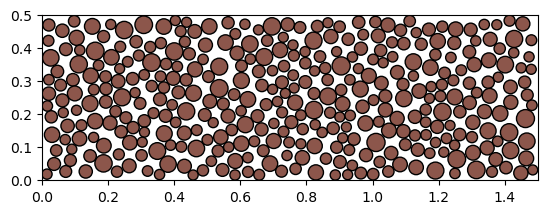

In [111]:
plot(cirList)

## 2D compaction algorithm

### Discretization of simulation domain

In [122]:
thickness = r_min - 0.001
num_domains = math.floor(height_box/thickness)
max_agg_line = math.floor(width_box/d_min)
thickness = round(height_box/num_domains,3)

cirList_np = np.array(cirList)
print(cirList_np)


[[0.28511162 0.41905897 0.01862613]
 [0.51820152 0.17431694 0.01516729]
 [1.35183538 0.36281216 0.02242173]
 ...
 [0.35590618 0.01729956 0.01546807]
 [1.24834262 0.1062041  0.01538655]
 [0.90984545 0.12802883 0.01525796]]


In [137]:
discret_domains = np.zeros([num_domains,max_agg_line,3]) #3 information per circle (x,y,r)

for j,t in enumerate(discret_domains):
    condensed_list = cirList_np[np.where((cirList_np[:,1]<=j*thickness+thickness) & (cirList_np[:,1]>=j*thickness))]
    for i,s in enumerate(condensed_list):
        t[i,:]=s 

